In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-baru/Normalisasi_data.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier

In [3]:
df = pd.read_csv('/kaggle/input/data-baru/Normalisasi_data.csv')

df.head()

,AU24,Eye_Open_Avg,Facial_Structure,AU23,AU01,AU07,AU02,AU_Smile,AU10,AU14,Head_Movement,AU_Sad,datetime,depression_episode,pid
0,-11.351092,0.973326,0.567567,-2.459438,-11.097750,18.764470,-13.701491,1.797318,-7.621264,-8.416746,0.093635,0.861408,2022-07-21 04:46,0,P08
1,-11.351092,0.973326,0.567567,-2.459438,-11.097750,18.764470,-13.701491,1.797318,-7.621264,-8.416746,0.093635,0.861408,2022-07-21 04:46,0,P08
2,-12.812418,0.824679,0.584101,-2.705608,-8.061482,13.727324,-12.742016,1.416385,-0.372542,-13.412502,0.094856,0.250375,2022-07-21 04:46,0,P08
3,-12.812418,0.824679,0.584101,-2.705608,-8.061482,13.727324,-12.742016,1.416385,-0.372542,-13.412502,0.094856,0.250375,2022-07-21 04:46,0,P08
4,-9.396528,0.905175,0.609942,0.163664,-5.724306,22.029821,-9.810085,1.645429,-4.372520,-3.623914,0.095847,2.480238,2022-07-21 04:46,0,P08


In [4]:
print("Tipe Data Setiap Kolom:")
print(df.dtypes)

print("\nDistribusi nilai 'depression_episode':")
print(df['depression_episode'].value_counts())

categorical_cols = ['pid', 'datetime']
for col in categorical_cols:
    print(f"\nDistribusi nilai untuk kolom '{col}':")
    print(df[col].value_counts())

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("\nStatistik deskriptif untuk kolom numerik:")
print(df[numerical_cols].describe())

Tipe Data Setiap Kolom:
AU24                  float64
Eye_Open_Avg          float64
Facial_Structure      float64
AU23                  float64
AU01                  float64
AU07                  float64
AU02                  float64
AU_Smile              float64
AU10                  float64
AU14                  float64
Head_Movement         float64
AU_Sad                float64
datetime               object
depression_episode      int64
pid                    object
dtype: object

Distribusi nilai 'depression_episode':
depression_episode
0    420061
1    332359
Name: count, dtype: int64

Distribusi nilai untuk kolom 'pid':
pid
P16    114558
P08     93342
P24     78616
P30     62096
P29     58222
P35     44554
P33     35658
P15     27710
P23     27196
P18     26722
P13     22304
P21     21864
P19     20836
P14     20146
P38     18670
P31     14654
P10     14560
P36     12556
P20     10982
P12      8180
P28      7365
P17      5554
P34      4738
P25      1326
P27        11
Name: count,

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Evaluasi Berdasarkan pid:
     pid  Accuracy  Precision    Recall  F1 Score       AUC
0   P08  0.924600   0.873983  0.923952  0.898273  0.986407
1   P10  0.985700   0.988587  0.984280  0.986429  0.999408
2   P12  0.972127   0.939418  0.969943  0.954436  0.998096
3   P13  0.983100   0.672304  0.957831  0.790062  0.998255
4   P14  0.950700   0.997602  0.951055  0.973772  0.992268
5   P15  0.976600   0.966300  0.976314  0.971281  0.998442
6   P16  0.937200   0.912785  0.942036  0.927180  0.990666
7   P18  0.951000   0.948746  0.962292  0.955471  0.993975
8   P19  0.995000   0.991501  0.998122  0.994800  0.999932
9   P20  0.979700   0.979198  0.977312  0.978254  0.998885
10  P21  0.973100   0.959206  0.982317  0.970624  0.998070
11  P23  0.970900   0.966313  0.958612  0.962447  0.997581
12  P24  0.981700   0.953691  0.982072  0.967674  0.998931
13  P29  0.936900   0.913591  0.971106  0.941471  0.991900
14  P30  0.921200   0.901335  0.949961  0.925010  0.986000
15  P31  0.994600   0.988956

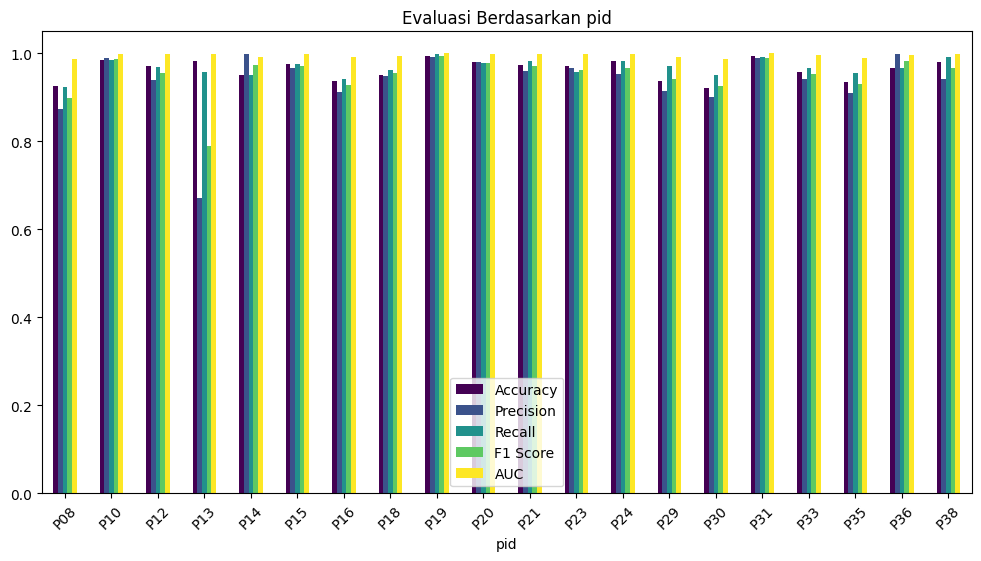

In [5]:
#Resampling Data
max_samples = 10000
df_balanced = pd.concat([
    resample(df[df['pid'] == pid], n_samples=max_samples, random_state=42) 
    if len(df[df['pid'] == pid]) > max_samples else df[df['pid'] == pid] 
    for pid in df['pid'].unique()
])

# Split Data
X = df_balanced.drop(columns=['depression_episode', 'datetime', 'pid'])
y = df_balanced['depression_episode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE untuk menangani ketidakseimbangan kelas
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Normalisasi & PCA
scaler, pca = StandardScaler(), PCA(n_components=0.95)
X_train = pca.fit_transform(scaler.fit_transform(X_train))
X_test = pca.transform(scaler.transform(X_test))

# Hyperparameter Tuning & Model Training
param_dist = {'n_estimators': randint(100, 500), 'max_depth': randint(5, 50)}
best_et = RandomizedSearchCV(ExtraTreesClassifier(random_state=42), param_dist, cv=3, n_iter=10, random_state=42, n_jobs=-1).fit(X_train, y_train).best_estimator_
best_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_dist, cv=3, n_iter=10, random_state=42, n_jobs=-1).fit(X_train, y_train).best_estimator_

stacking_model = StackingClassifier(estimators=[('et', best_et), ('xgb', best_xgb)], final_estimator=LogisticRegression(), cv=3, n_jobs=-1)
stacking_model.fit(X_train, y_train)

# Evaluasi Berdasarkan 'pid'
evaluasi = []
for pid in df_balanced['pid'].unique():
    X_pid = pca.transform(scaler.transform(df_balanced[df_balanced['pid'] == pid].drop(columns=['depression_episode', 'datetime', 'pid'])))
    y_pid = df_balanced[df_balanced['pid'] == pid]['depression_episode']
    
    if len(np.unique(y_pid)) < 2: continue  # Lewati jika hanya satu kelas
    
    y_pred_pid = stacking_model.predict(X_pid)
    y_proba_pid = stacking_model.predict_proba(X_pid)[:, 1]
    
    evaluasi.append({
        'pid': pid,
        'Accuracy': accuracy_score(y_pid, y_pred_pid),
        'Precision': precision_score(y_pid, y_pred_pid, zero_division=0),
        'Recall': recall_score(y_pid, y_pred_pid, zero_division=0),
        'F1 Score': f1_score(y_pid, y_pred_pid, zero_division=0),
        'AUC': roc_auc_score(y_pid, y_proba_pid)
    })

df_evaluasi = pd.DataFrame(evaluasi)
print("\nEvaluasi Berdasarkan pid:\n", df_evaluasi)

# Visualisasi Evaluasi
df_evaluasi.set_index('pid').plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Evaluasi Berdasarkan pid')
plt.xticks(rotation=45)
plt.show()

In [6]:
joblib.dump(stacking_model, 'hybrid_model.pkl')

print("Model berhasil disimpan sebagai 'hybrid_model.pkl'")

Model berhasil disimpan sebagai 'hybrid_model.pkl'


In [ ]:
joblib.dump(stacking_model, 'model_hybrid.pkl', compress=3)
print("Model lebih kecil disimpan")